<a href="https://colab.research.google.com/github/JohnYechanJo/Novo-Nordisk_Anomaly-Detection/blob/classifier/1st_stage_fixed_PGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Synthetic CNV Image Classifier
This notebook uses CNV images from the OCT2017 dataset to generate synthetic CNV images using a Stable Diffusion model. The synthetic images are then mixed with Normal CNV images at various ratios (0% to 100%) to train a classifier. The goal is to find the optimal ratio of synthetic images to maximize classifier performance.

Execution Steps:

1. Data Preprocessing: OCT2017 CNV/NORMAL images → ViT embeddings → pre-trained_dataset.pt.

2. Diffusion Model Fine-tuning: Fine-tune Stable Diffusion UNet with CNV images.

3. Synthetic CNV Image Generation: Generate images using the fine-tuned model → ViT embeddings → synthetic_cnv_dataset.pt.

4. Classifier Training by Ratio: Mix data at synthetic ratios from 0% to 100% → Train classifier → Compare performance.

Execution Environment: Google Colab (GPU, e.g., T4 or A100 recommended).

##1. Environment Setup and Package Installation
Install the required Python packages and set the random seed to ensure reproducibility. GPU will be utilized, and functions for memory management will also be defined

In [1]:
!pip install kagglehub torch torchvision transformers diffusers accelerate datasets xformers pytorch-fid pandas
import os
import gc
import torch
import numpy as np
import random
from PIL import Image
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from transformers import ViTModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler, StableDiffusionPipeline
from accelerate import Accelerator
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from pytorch_fid import fid_score

# Set random seed
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Memory cleanup function
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()

INFO: pip is looking at multiple versions of xformers to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 k

##2. Diffusion Model Fine-tuning
Fine-tune the UNet of the Stable Diffusion model using CNV images.
Download the dataset from Kaggle, preprocess the CNV images, and use them for training.
The trained model will be saved to `/content/models/sd_cnv_finetuned.`

###2.1 Data Preparation
Download CNV images from the Kaggle dataset, resize them to 512x512, and save them to `/content/processed/CNV/.`

In [2]:
import kagglehub
import os
from PIL import Image

def prepare_cnv_images():
    # Kaggle dataset download
    path = kagglehub.dataset_download("paultimothymooney/kermany2018")
    print(f"Dataset downloaded to: {path}")

    # Set dataset path and copy CNV images
    in_dir = os.path.join(path, "OCT2017 /train/CNV")
    out_dir = "/content/processed/CNV/"
    os.makedirs(out_dir, exist_ok=True)
    for fn in os.listdir(in_dir):
        img = Image.open(os.path.join(in_dir, fn)).convert("RGB")
        img = img.resize((512, 512), resample=Image.LANCZOS)
        img.save(os.path.join(out_dir, fn))
    print(f"Processed CNV images saved to {out_dir}")

prepare_cnv_images()

Dataset downloaded to: /kaggle/input/kermany2018
Processed CNV images saved to /content/processed/CNV/


###2.2 Define Dataset Class
Define the `ImgDataset` class to load CNV images and transform them into the format required for training.

In [3]:
from torch.utils.data import Dataset
from torchvision import transforms

class ImgDataset(Dataset):
    def __init__(self, root_dir:str, tokenizer, cohort:str = "CNV", resolution=512, max_length=77, dataset_size:int = 6400) -> None:
        self.files = [
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.lower().endswith((".png", ".jpg", ".jpeg"))
        ]
        if len(self.files) > dataset_size: self.files = self.files[:dataset_size]
        self.tokenizer = tokenizer
        self.transform = transforms.Compose([
            transforms.Resize((resolution, resolution), transforms.InterpolationMode.LANCZOS),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        self.prompt = f"OCT scan showing {cohort}"
        self.max_length = max_length

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx:int) -> dict:
        img = Image.open(self.files[idx]).convert("RGB")
        img = self.transform(img)
        tokens = self.tokenizer(
            self.prompt,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {"pixel_values": img, "input_ids": tokens.input_ids.squeeze(0)}

###2.3 Define Training Function
Define the `train` function to fine-tune the Stable Diffusion UNet using CNV images. It supports mixed precision training and checkpoint saving.

In [4]:
import torch
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL, UNet2DConditionModel, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from accelerate import Accelerator

def train(
    pretrained_model: str,
    data_dir: str,
    output_dir: str = "sd_cnv_finetuned",
    cohort: str = "CNV",
    resolution: int = 512,
    dataset_size: int = 6400,
    batch_size: int = 4,
    learning_rate: float = 1e-4,
    epochs: int = 5,
    grad_accum_steps: int = 1,
    save_steps: int = 1000,
    resume_checkpoint: str = None,
    unet: UNet2DConditionModel = None,
    accelerator: Accelerator = None,
):
    # 1) Prepare output directory, accelerator & device
    os.makedirs(output_dir, exist_ok=True)
    accel = accelerator or Accelerator()
    device = accel.device

    # 2) Load or resume UNet
    if resume_checkpoint and unet is None:
        unet = UNet2DConditionModel.from_pretrained(resume_checkpoint).to(device)
    elif unet is None:
        unet = UNet2DConditionModel.from_pretrained(pretrained_model, subfolder="unet").to(device)

    # 3) Load & freeze tokenizer + text encoder
    tokenizer = CLIPTokenizer.from_pretrained(pretrained_model, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(pretrained_model, subfolder="text_encoder").to(device)
    text_encoder.requires_grad_(False)

    # 4) Load & freeze VAE
    vae = AutoencoderKL.from_pretrained(pretrained_model, subfolder="vae").to(device)
    vae.requires_grad_(False)

    # 5) Load noise scheduler
    scheduler = DDPMScheduler.from_pretrained(pretrained_model, subfolder="scheduler")

    # 6) Prepare dataset & dataloader
    dataset = ImgDataset(data_dir, tokenizer, cohort=cohort, resolution=resolution, dataset_size=dataset_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # 7) Optimizer (only UNet params)
    optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

    # 8) Wrap models, optimizer, and dataloader for mixed-precision / distributed
    unet, optimizer, dataloader = accel.prepare(unet, optimizer, dataloader)

    # 9) Resume state if requested
    if resume_checkpoint:
        accel.load_state(resume_checkpoint)
        global_step = int(resume_checkpoint.rsplit("_", 1)[-1])
    else:
        global_step = 0

    # 10) Training loop
    for epoch in range(1, epochs + 1):
        unet.train()
        for batch in dataloader:
            with accel.accumulate(unet):
                # Encode images to latents
                pixels = batch["pixel_values"].to(device)
                latents = vae.encode(pixels).latent_dist.sample() * 0.18215

                # Add noise
                noise = torch.randn_like(latents)
                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (latents.shape[0],), device=device)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)

                # Text conditioning
                input_ids = batch["input_ids"].to(device)
                encoder_hidden_states = text_encoder(input_ids)[0]

                # Noise prediction & loss
                pred_noise = unet(noisy_latents, timesteps, encoder_hidden_states).sample
                loss = torch.nn.functional.mse_loss(pred_noise, noise)

                # Backpropagate
                accel.backward(loss)
                optimizer.step()
                optimizer.zero_grad()

            global_step += 1
            if global_step % save_steps == 0:
                accel.wait_for_everyone()
                ckpt_dir = os.path.join(output_dir, f"checkpoint_{global_step}")
                unet.save_pretrained(ckpt_dir)
                if accel.is_main_process:
                    tokenizer.save_pretrained(ckpt_dir)
                accel.save_state(ckpt_dir)

        print(f"Epoch {epoch}/{epochs} complete")

    # 11) Final save
    accel.wait_for_everyone()
    final_dir = os.path.join(output_dir, "final_unet")
    unet.save_pretrained(final_dir)
    if accel.is_main_process:
        tokenizer.save_pretrained(output_dir)
    print("Fine-tuning complete — models saved to", output_dir)

###2.4 Execute Diffusion Model Training
Use the pre-trained model (`nota-ai/bk-sdm-small`) to fine-tune with CNV images.

In [5]:
from accelerate import Accelerator

# Accelerator initialization
accel = Accelerator()

# Excute Diffusion Model training
train(
    pretrained_model="nota-ai/bk-sdm-small",
    data_dir="/content/processed/CNV",
    output_dir="/content/models/sd_cnv_finetuned",
    cohort="CNV",
    resolution=512,
    dataset_size=500,  # Consideration of Training Time
    batch_size=4,
    learning_rate=1e-4,
    epochs=10,
    grad_accum_steps=1,
    save_steps=1000,
    resume_checkpoint=None,
    accelerator=accel
)

# Memory clean up
clear_memory()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.93G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

Epoch 1/10 complete
Epoch 2/10 complete
Epoch 3/10 complete
Epoch 4/10 complete
Epoch 5/10 complete
Epoch 6/10 complete
Epoch 7/10 complete
Epoch 8/10 complete
Epoch 9/10 complete
Epoch 10/10 complete
Fine-tuning complete — models saved to /content/models/sd_cnv_finetuned


##3. Generate Synthetic CNV Images
Use the fine-tuned Diffusion Model to generate synthetic CNV images, and create ViT embeddings. The embeddings will then be saved to `synthetic_cnv_dataset.pt.`

In [ ]:
# VIT Processing
def img_transform():
    return transforms.Compose([
        transforms.Lambda(lambda img: img.crop((0, 100, 768, 400))),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
def vit_process(img_list, batch_size=16):
    model_name = "google/vit-base-patch16-224"
    vit_model = ViTModel.from_pretrained(model_name, output_hidden_states=True).to(device)
    vit_model.eval()
    length = len(img_list)
    layers_0, layers_1, layers_2, layers_3 = [], [], [], []
    for i in range(int(length/batch_size)):
        batch_imgs = img_list[i*batch_size:(i+1)*batch_size]
        batch_tensor = torch.stack(batch_imgs, dim=0).to(device)
        with torch.no_grad():
            outputs = vit_model(pixel_values=batch_tensor)
        hidden = outputs.hidden_states
        last_layer = hidden[12][:,0,:]
        hidden_layer_1 = torch.zeros_like(last_layer)
        hidden_layer_2 = torch.zeros_like(last_layer)
        hidden_layer_3 = torch.zeros_like(last_layer)
        for j in range(12):
            if j < 4:
                hidden_layer_1 += hidden[j][:,0,:]/4
            elif j < 8:
                hidden_layer_2 += hidden[j][:,0,:]/4
            else:
                hidden_layer_3 += hidden[j][:,0,:]/4
        layers_0.append(last_layer)
        layers_1.append(hidden_layer_1)
        layers_2.append(hidden_layer_2)
        layers_3.append(hidden_layer_3)
        clear_memory()
    return (torch.cat(layers_0, dim=0), torch.cat(layers_1, dim=0),
            torch.cat(layers_2, dim=0), torch.cat(layers_3, dim=0))
# Images Transfer to Tensors
def load_trans(path, pic_num=640):
    trans_toTensor = img_transform()
    image_list = []
    i = 0
    for filename in os.listdir(path):
        if i == pic_num:
            break
        file_path = os.path.join(path, filename)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            try:
                img = Image.open(file_path).convert("RGB")
                tensor_img = trans_toTensor(img)
                image_list.append(tensor_img)
            except Exception as e:
                print(f"Skip: {filename}, Error: {e}")
        i += 1
    return image_list

# Cell 10: Generate Synthetic CNV Images
def generate_synthetic_images(
    base_model: str = "nota-ai/bk-sdm-small",
    unet_dir: str = "/content/models/sd_cnv_textinv/final/unet",
    output_dir: str = "/content/synthetic_cnv",
    total: int = 640,
    chunk_size: int = 32,
    num_inference_steps: int = 50,
    guidance_scale: float = 7.5,
):
    # Load the Base Pipeline from the Original Model
    pipeline = StableDiffusionPipeline.from_pretrained(
        "nota-ai/bk-sdm-small",
        torch_dtype=torch.float16,
        use_auth_token=False
    ).to(device)

    # Load the Fine-tuned UNet
    unet = UNet2DConditionModel.from_pretrained(
        "/content/models/sd_cnv_finetuned/final_unet",
        torch_dtype=torch.float16
    ).to(device)

    # Replace the UNet in the Pipeline
    pipeline.unet = unet

    # Generate Synthetic Images
    synthetic_dir = "/content/synthetic_cnv/"
    os.makedirs(synthetic_dir, exist_ok=True)
    num_images = 640
    prompt = (
    "High-resolution grayscale OCT scan of the human retina showing retinal abnormalities. "
    "Clear layer definition, with details of retinal features. Dark background, minimal color, realistic biomedical texture."
    )

    gen = torch.Generator(device=device)
    idx = 0

    for start in range(0, total, chunk_size):
        n = min(chunk_size, total - start)
        prompts = [prompt for _ in range(n)]
        results = pipeline(
            prompts,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=gen
        )
        # Handle absence of nsfw_content_detected when safety_checker=None
        flagged_list = results.nsfw_content_detected if results.nsfw_content_detected is not None else [False] * len(results.images)
        for image, flagged in zip(results.images, flagged_list):
            if flagged:
                continue
            path = os.path.join(output_dir, f"synthetic_cnv_{idx:04d}.png")
            image.save(path)
            idx += 1
        # Free memory each chunk
        del results, image
        gc.collect()
        torch.cuda.empty_cache()
        print(f"Generated {idx}/{total} images")
        if idx >= total:
            break

    # ViT embeddings on synthetic set
    tensor_list = load_trans(output_dir, pic_num=idx)
    out_00, out_01, out_02, out_03 = vit_process(tensor_list)

    # Save synthetic dataset
    torch.save({
        'data_0': out_00,
        'data_1': out_01,
        'data_2': out_02,
        'data_3': out_03,
    }, 'synthetic_cnv_dataset.pt')
    print(f"Synthetic CNV dataset (n={idx}) saved to synthetic_cnv_dataset.pt")

generate_synthetic_images()
clear_memory()

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': False} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated 0/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 50/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated 100/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated 150/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 200/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 250/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated 300/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated 350/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated 400/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 450/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Generated 500/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated 550/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Generated 600/640 images


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Synthetic CNV dataset saved to synthetic_cnv_dataset.pt


##4. Training Sets Preprocessing:
OCT2017 Dataset & Synthetic Dataset → Mixed Embedding Trainig Dataset
1. Load CNV and NORMAL images from the `OCT2017 dataset` and Synthetic CNV tensors from `synthetic_cnv_dataset.pt.`,
2. Trans images to tensors and mix tensor-embeddings together using fixed ratio
3. The resulting embeddings will be saved to a file named `pre-trained_dataset.pt.`

In [ ]:
def preprocess_data():
    print("Data Preprocessing: Start!")
    import kagglehub
    path = kagglehub.dataset_download("paultimothymooney/kermany2018")
    loadpath = os.path.join(path, "OCT2017 /train")
    train_path_cnv = os.path.join(loadpath, "CNV")
    train_path_normal = os.path.join(loadpath, "NORMAL")
    # 640：640-> 1280->640:640 -> 1600->1280(64:64):160(80:80):160(train/val/test)
    cnv_tensor_list = load_trans(train_path_cnv, pic_num = 800)
    normal_tensor_list = load_trans(train_path_normal,  pic_num = 800)
    # Real CNV Tensors : 800,768
    out_00, out_01, out_02, out_03 = vit_process(cnv_tensor_list)
    # Real Normal Tensors : 800,768
    out_10, out_11, out_12, out_13 = vit_process(normal_tensor_list)
    # Load Synthetic CNV Tensors : 640,768
    synthetic_cnv_data = torch.load('synthetic_cnv_dataset.pt')
    # 10, 1, 1 -> train(64:64), val(80:80), test(80:80)
    batch_size, half_batch, batch_num = 128, 64, 10
    # Fix ratio
    ratio = 0.1

    # Define category size per training batch
    print(f"\nMixing with Synthetic Ratio: {ratio*100:.0f}%")
    num_synthetic_batch = int(64 * ratio)
    num_normal_cnv_batch = 64 - num_synthetic_batch
    mixed_data_0 = []
    mixed_data_1 = []
    mixed_data_2 = []
    mixed_data_3 = []
    labels_list = []

    # Shuffle Training Sets
    for i in range(batch_num):
        # Create balanced labels (half CNV, half normal)
        labels = torch.cat([torch.zeros(half_batch, dtype=torch.long),
                              torch.ones(half_batch, dtype=torch.long)], dim=0)
        # Select data for the batch
        s_cnv_0 = synthetic_cnv_data['data_0'][i*num_synthetic_batch:(i+1)*num_synthetic_batch]
        s_cnv_1 = synthetic_cnv_data['data_1'][i*num_synthetic_batch:(i+1)*num_synthetic_batch]
        s_cnv_2 = synthetic_cnv_data['data_2'][i*num_synthetic_batch:(i+1)*num_synthetic_batch]
        s_cnv_3 = synthetic_cnv_data['data_3'][i*num_synthetic_batch:(i+1)*num_synthetic_batch]
        n_cnv_0 = out_00[i*num_normal_cnv_batch:(i+1)*num_normal_cnv_batch]
        n_cnv_1 = out_01[i*num_normal_cnv_batch:(i+1)*num_normal_cnv_batch]
        n_cnv_2 = out_02[i*num_normal_cnv_batch:(i+1)*num_normal_cnv_batch]
        n_cnv_3 = out_03[i*num_normal_cnv_batch:(i+1)*num_normal_cnv_batch]
        n_normal_0 = out_10[i*half_batch:(i+1)*half_batch]
        n_normal_1 = out_11[i*half_batch:(i+1)*half_batch]
        n_normal_2 = out_12[i*half_batch:(i+1)*half_batch]
        n_normal_3 = out_13[i*half_batch:(i+1)*half_batch]
        # Shuffle indices
        indices = torch.randperm(batch_size)
        # Compose and shuffle batch
        compose_batch_0 = torch.cat([s_cnv_0, n_cnv_0, n_normal_0], dim=0)
        compose_batch_1 = torch.cat([s_cnv_1, n_cnv_1, n_normal_1], dim=0)
        compose_batch_2 = torch.cat([s_cnv_2, n_cnv_2, n_normal_2], dim=0)
        compose_batch_3 = torch.cat([s_cnv_3, n_cnv_3, n_normal_3], dim=0)
        mixed_data_0.append(compose_batch_0[indices])
        mixed_data_1.append(compose_batch_1[indices])
        mixed_data_2.append(compose_batch_2[indices])
        mixed_data_3.append(compose_batch_3[indices])
        labels_list.append(labels[indices])

    # Add Val Sets
    i, j = batch_num*num_normal_cnv_batch, batch_num*half_batch
    n_cnv_0 = out_00[i:i+80]
    n_cnv_1 = out_01[i:i+80]
    n_cnv_2 = out_02[i:i+80]
    n_cnv_3 = out_03[i:i+80]
    n_normal_0 = out_10[j:j+80]
    n_normal_1 = out_11[j:j+80]
    n_normal_2 = out_12[j:j+80]
    n_normal_3 = out_13[j:j+80]
    labels = torch.cat([torch.zeros(80, dtype=torch.long),
                              torch.ones(80, dtype=torch.long)], dim=0)
    compose_batch_0 = torch.cat([n_cnv_0, n_normal_0], dim=0)
    compose_batch_1 = torch.cat([n_cnv_1, n_normal_1], dim=0)
    compose_batch_2 = torch.cat([n_cnv_2, n_normal_2], dim=0)
    compose_batch_3 = torch.cat([n_cnv_3, n_normal_3], dim=0)
    mixed_data_0.append(compose_batch_0)
    mixed_data_1.append(compose_batch_1)
    mixed_data_2.append(compose_batch_2)
    mixed_data_3.append(compose_batch_3)
    labels_list.append(labels)

    # Add Test Sets
    i, j = i+80, j+80
    n_cnv_0 = out_00[i:i+80]
    n_cnv_1 = out_01[i:i+80]
    n_cnv_2 = out_02[i:i+80]
    n_cnv_3 = out_03[i:i+80]
    n_normal_0 = out_10[j:j+80]
    n_normal_1 = out_11[j:j+80]
    n_normal_2 = out_12[j:j+80]
    n_normal_3 = out_13[j:j+80]
    labels = torch.cat([torch.zeros(80, dtype=torch.long),
                              torch.ones(80, dtype=torch.long)], dim=0)
    compose_batch_0 = torch.cat([n_cnv_0, n_normal_0], dim=0)
    compose_batch_1 = torch.cat([n_cnv_1, n_normal_1], dim=0)
    compose_batch_2 = torch.cat([n_cnv_2, n_normal_2], dim=0)
    compose_batch_3 = torch.cat([n_cnv_3, n_normal_3], dim=0)
    mixed_data_0.append(compose_batch_0)
    mixed_data_1.append(compose_batch_1)
    mixed_data_2.append(compose_batch_2)
    mixed_data_3.append(compose_batch_3)
    labels_list.append(labels)

    # Concatenate all batches
    mixed_data_0 = torch.cat(mixed_data_0, dim=0)
    mixed_data_1 = torch.cat(mixed_data_1, dim=0)
    mixed_data_2 = torch.cat(mixed_data_2, dim=0)
    mixed_data_3 = torch.cat(mixed_data_3, dim=0)
    mixed_labels = torch.cat(labels_list, dim=0)

    if os.path.exists('pre-trained_dataset.pt'):
        os.remove('pre-trained_dataset.pt')
    torch.save({'data_0': mixed_data_0, 'data_1': mixed_data_1, 'data_2': mixed_data_2, 'data_3': mixed_data_3, 'label': mixed_labels}, 'pre-trained_dataset.pt')
    print('Data Preprocessing: Done!')

preprocess_data()
clear_memory()

Data Preprocessing: Start!


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Mixing with Synthetic Ratio: 10%
Data Preprocessing: Done!


##5. Define Classifier Model
Define a classifier model that takes ViT embeddings as input and classifies the images into CNV and NORMAL categories.

In [ ]:
import torch.nn as nn
import torch.nn.init as init
import abc

class PGD(object):
    def __init__(self, model, emb_name, epsilon=0.6, alpha=0.15):
        self.model = model
        self.emb_name = emb_name
        self.epsilon = epsilon
        self.alpha = alpha
        self.emb_backup = {}
        self.grad_backup = {}
    def attack(self, is_first_attack=False):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if self.emb_name in name:
                    if is_first_attack:
                        self.emb_backup[name] = param.data.clone()
                    if name in self.emb_backup:
                        norm = torch.norm(param.grad)
                        if norm != 0:
                            r_at = self.alpha * param.grad / norm
                            param.data.add_(r_at) # add random perturbation
                            param.data = self.project(name, param.data, self.epsilon)
    def restore(self): # restore
        for name, param in self.model.named_parameters():
            if param.requires_grad and self.emb_name in name:
                assert name in self.emb_backup
                param.data = self.emb_backup[name]
        self.emb_backup = {}
    def project(self, param_name, param_data, epsilon):
        if param_name not in self.emb_backup:
            return param_data
        r = param_data - self.emb_backup[param_name]
        if torch.norm(r) > epsilon: # limit the parameters size after pertubation，epsilon=6
            r = epsilon * r / torch.norm(r) # if the L2 norm of a vector exceeds a threshold, clip it to the threshold
        return self.emb_backup[param_name] + r
    def backup_grad(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                self.grad_backup[name] = param.grad.clone()
    def restore_grad(self): # restore grad
        for name, param in self.model.named_parameters():
            if param.requires_grad and param.grad is not None:
                if name in self.grad_backup:
                    param.grad = self.grad_backup[name]

class TransformerBlock(nn.Module):
    def __init__(self, input_size, head_num=10):
        super(TransformerBlock, self).__init__()
        self.input_size = input_size
        self.head_num = head_num
        self.query = nn.Linear(input_size, input_size)
        self.key = nn.Linear(input_size, input_size)
        self.value = nn.Linear(input_size, input_size)
        self.multihead = nn.MultiheadAttention(input_size, head_num)
        self.dropout = nn.Dropout(0.3)
        self.norm = nn.LayerNorm(input_size)
        self.linear = nn.Linear(input_size, input_size)

    def forward(self, q, k, v):
        q = self.query(q)
        k = self.key(k)
        v = self.value(v)
        attn_output, _ = self.multihead(q, k, v)
        attn_output = self.dropout(attn_output)
        output = self.norm(attn_output + q)
        output = self.linear(output)
        output = self.dropout(output)
        output = self.norm(output + attn_output)
        return output

class EncoderBlock(nn.Module):
    def __init__(self, input_dim=768, hidden_dim_1=900, hidden_dim_2=450, attn_drop=0.15):
        super(EncoderBlock, self).__init__()
        self.attn_drop = attn_drop
        dataset_dic = torch.load('pre-trained_dataset.pt')
        embedding_weights_0 = dataset_dic['data_0']
        embedding_weights_1 = dataset_dic['data_1']
        embedding_weights_2 = dataset_dic['data_2']
        embedding_weights_3 = dataset_dic['data_3']
        total = 1600
        self.embedding_layer_0 = nn.Embedding(num_embeddings=total, embedding_dim=input_dim, padding_idx=0, _weight=embedding_weights_0)
        self.embedding_layer_1 = nn.Embedding(num_embeddings=total, embedding_dim=input_dim, padding_idx=0, _weight=embedding_weights_1)
        self.embedding_layer_2 = nn.Embedding(num_embeddings=total, embedding_dim=input_dim, padding_idx=0, _weight=embedding_weights_2)
        self.embedding_layer_3 = nn.Embedding(num_embeddings=total, embedding_dim=input_dim, padding_idx=0, _weight=embedding_weights_3)
        self.linear_1 = nn.Linear(input_dim, hidden_dim_1)
        self.linear_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.linear_3 = nn.Linear(hidden_dim_2, hidden_dim_1)
        self.dropout = nn.Dropout(attn_drop)
        self.relu = nn.ReLU()
        self.norm = nn.LayerNorm(hidden_dim_1)  # Add for Residual Connection Stabilization
        self.__init_weights__()

    def __init_weights__(self):
        init.xavier_normal_(self.linear_1.weight)
        init.xavier_normal_(self.linear_2.weight)
        init.xavier_normal_(self.linear_3.weight)

    def forward(self, layer_id=0, X_id=0):
        if torch.is_tensor(X_id):
            X_id = X_id.to(device)
            if layer_id == 0:
                X_ = self.embedding_layer_0(X_id).to(torch.float32)
            elif layer_id == 1:
                X_ = self.embedding_layer_1(X_id).to(torch.float32)
            elif layer_id == 2:
                X_ = self.embedding_layer_2(X_id).to(torch.float32)
            elif layer_id == 3:
                X_ = self.embedding_layer_3(X_id).to(torch.float32)
        else:
            print("Non-standard use of encoderblock!")
        residual = self.relu(self.linear_1(X_))
        x_ = self.relu(self.dropout(self.linear_2(residual)))
        x_ = self.linear_3(x_)
        x_ = self.norm(x_ + residual)  # Add LayerNorm
        return x_

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.best_acc = 0
        self.init_clip_max_norm = None

    @abc.abstractmethod
    def forward(self):
        pass

    def fit(self, x_train, y_train, x_val, y_val, x_test, y_test):
        if torch.cuda.is_available():
            self.cuda()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=4e-5, weight_decay=1e-5)  # add weight_decay
        dataset = TensorDataset(x_train, y_train)
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)  # Decrease Batch Size
        loss = nn.CrossEntropyLoss()
        epochs = 15
        pgd_block = PGD(self,emb_name = 'embedding_layer',epsilon=6,alpha=1.8)
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")
            self.train()
            for i, data in enumerate(dataloader):
                total = len(dataloader)
                batch_x_id, batch_y = (item.cuda() for item in data)
                self.batch_dealer(batch_x_id, batch_y, loss, i, epoch+1, total,pgd_block)
            self.batch_evaluate(x_val, y_val)

    def batch_dealer(self, x_id, y, loss, i, epoch, total,pgd_block):
        self.optimizer.zero_grad()
        logit_original = self.forward(x_id, epoch=epoch)
        loss_classify = loss(logit_original, y)

        K = 2# PGD

        pgd_block.backup_grad()
        for t in range(K):
            pgd_block.attack(is_first_attack=(t == 0))
            if t != K - 1:
                self.zero_grad()
            else:
                pgd_block.restore_grad()

            loss_adv= self.forward(x_id)
            loss_adv = loss(loss_adv,y)
            loss_adv.backward()


        loss_classify.backward()
        self.optimizer.step()
        corrects = (torch.max(logit_original, 1)[1].view(y.size()).data == y.data).sum()
        accuracy = 100 * corrects / len(y)
        print(f'Batch[{i + 1}/{total}] - loss: {loss_classify.item():.6f}  accuracy: {accuracy:.4f}%({corrects}/{y.size(0)})')

    def batch_evaluate(self, x, y):
        y_pred = self.predicter(x)
        acc = accuracy_score(y, y_pred)
        if acc > self.best_acc:
            self.best_acc = acc
        # Debug Class Distribution
        print("y_true classes:", np.unique(y))
        print("y_pred classes:", np.unique(y_pred))
        # Specify Labels in classification_report
        try:
            print(classification_report(y, y_pred, labels=[0, 1], target_names=['NR', 'FR'], digits=5))
        except ValueError as e:
            print(f"Error in classification_report: {e}")
            print("Skipping classification report due to single class prediction")
        print("Val set acc:", acc)
        print("Best val set acc:", self.best_acc)

    def predicter(self, x):
        if torch.cuda.is_available():
            self.cuda()
        self.eval()
        y_pred = []
        dataset = TensorDataset(x)
        dataloader = DataLoader(dataset, batch_size=16)
        for i, data in enumerate(dataloader):
            with torch.no_grad():
                batch_x_id = data[0].cuda()
                logits = self.forward(batch_x_id)
                predicted = torch.max(logits, dim=1)[1]
                y_pred += predicted.data.cpu().numpy().tolist()
        return y_pred

class Classifier(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.encoder_block = EncoderBlock()
        self.attention = TransformerBlock(input_size=300)
        self.dropout = nn.Dropout(0.6)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(3600, 300)
        self.fc1 = nn.Linear(300, 600)
        self.fc2 = nn.Linear(600, 300)
        self.fc3 = nn.Linear(in_features=300, out_features=2)
        self.init_weight()

    def init_weight(self):
        init.xavier_normal_(self.fc.weight)
        init.xavier_normal_(self.fc1.weight)
        init.xavier_normal_(self.fc2.weight)
        init.xavier_normal_(self.fc3.weight)

    def forward(self, x_id, epoch=0):
        batch_size = x_id.shape[0]
        x_id = x_id.cuda()
        embedding_0 = self.encoder_block(layer_id=0, X_id=x_id)
        embedding_1 = self.encoder_block(layer_id=1, X_id=x_id)
        embedding_2 = self.encoder_block(layer_id=2, X_id=x_id)
        embedding_3 = self.encoder_block(layer_id=3, X_id=x_id)
        embedding = torch.cat((embedding_0, embedding_1, embedding_2, embedding_3), dim=1)
        embedding = self.relu(self.fc(embedding))
        enhanced = self.attention(embedding.view(batch_size, 1, 300), embedding.view(batch_size, 1, 300), embedding.view(batch_size, 1, 300))
        enhanced = enhanced.squeeze(1)
        a1 = self.relu(self.dropout(self.fc1(enhanced)))
        a1 = self.relu(self.dropout(self.fc2(a1)))
        output = self.fc3(a1)
        return output

def train_and_test(model, x_train, y_train, x_val, y_val, x_test, y_test):
    nn = model
    nn.fit(x_train, y_train, x_val, y_val, x_test, y_test)
    y_pred = nn.predicter(x_test)
    print("Test y_true classes:", np.unique(y_test))
    print("Test y_pred classes:", np.unique(y_pred))
    try:
        res = classification_report(y_test, y_pred, labels=[0, 1], target_names=['NR', 'FR'], digits=3, output_dict=True)
        for k, v in res.items():
            print(k, v)
        print(f"result: {res['accuracy']:.4f}")
    except ValueError as e:
        print(f"Error in classification_report: {e}")
        res = {'accuracy': 0, 'macro avg': {'f1-score': 0, 'precision': 0, 'recall': 0}}
    return res

##6. Classifier Training and Result Analysis by Ratio
Train the classifier with a mixture of Synthetic CNV images and Normal CNV images at various ratios from 0% to 100%, and compare the performance. The results will be saved in `classifier_results.csv.`

In [ ]:
def train_classifier_with_ratios():
    dataset = torch.load('pre-trained_dataset.pt')
    mixed_labels = dataset['label']
    results = []
    x_train = torch.arange(0, 1280)
    x_val = torch.arange(1280, 1440)
    x_test = torch.arange(1440, 1600)
    y_train = mixed_labels[:1280]
    y_val = mixed_labels[1280:1440]
    y_test = mixed_labels[1440:1600]
    # Train and evaluate model
    model = Classifier()  # Assumes Classifier is defined elsewhere
    res = train_and_test(model, x_train, y_train, x_val, y_val, x_test, y_test)  # Assumes train_and_test is defined
    results.append({
        #'ratio': ratio,
        'accuracy': res['accuracy'],
        'f1_score': res['macro avg']['f1-score'],
        'precision': res['macro avg']['precision'],
        'recall': res['macro avg']['recall']
    })
    clear_memory()  # Assumes clear_memory is defined elsewhere

    # Print results
    print("\nResults Summary:")
    #for res in results:
       # print(f"Ratio: {res['ratio']*100:.0f}% | Accuracy: {res['accuracy']:.4f} | F1 Score: {res['f1_score']:.4f} | Precision: {res['precision']:.4f} | Recall: {res['recall']:.4f}")

    best_result = max(results, key=lambda x: x['accuracy'])
    #print(f"\nBest Ratio: {best_result['ratio']*100:.0f}%")
    print(f"Accuracy: {best_result['accuracy']:.4f}")
    print(f"F1 Score: {best_result['f1_score']:.4f}")
    print(f"Precision: {best_result['precision']:.4f}")
    print(f"Recall: {best_result['recall']:.4f}")

    # Save results to CSV
    pd.DataFrame(results).to_csv('classifier_results.csv', index=False)
    print("Results saved to classifier_results.csv")

# Run the function
train_classifier_with_ratios()


Epoch 1/15
Batch[1/20] - loss: 1.199509  accuracy: 46.8750%(30/64)
Batch[2/20] - loss: 1.318483  accuracy: 37.5000%(24/64)
Batch[3/20] - loss: 0.949809  accuracy: 53.1250%(34/64)
Batch[4/20] - loss: 1.288477  accuracy: 54.6875%(35/64)
Batch[5/20] - loss: 0.946147  accuracy: 45.3125%(29/64)
Batch[6/20] - loss: 0.928226  accuracy: 43.7500%(28/64)
Batch[7/20] - loss: 0.800586  accuracy: 65.6250%(42/64)
Batch[8/20] - loss: 0.912353  accuracy: 57.8125%(37/64)
Batch[9/20] - loss: 0.983330  accuracy: 51.5625%(33/64)
Batch[10/20] - loss: 0.742821  accuracy: 62.5000%(40/64)
Batch[11/20] - loss: 0.791423  accuracy: 57.8125%(37/64)
Batch[12/20] - loss: 0.777614  accuracy: 56.2500%(36/64)
Batch[13/20] - loss: 0.704663  accuracy: 65.6250%(42/64)
Batch[14/20] - loss: 0.801327  accuracy: 57.8125%(37/64)
Batch[15/20] - loss: 0.699005  accuracy: 62.5000%(40/64)
Batch[16/20] - loss: 0.948204  accuracy: 48.4375%(31/64)
Batch[17/20] - loss: 0.936276  accuracy: 46.8750%(30/64)
Batch[18/20] - loss: 0.95661

In [ ]:
import torch
import pandas as pd

def train_classifier_with_ratios():
    # Load dataset
    dataset = torch.load('pre-trained_dataset.pt')
    mixed_labels = dataset['label']
    results = []

    # Define train, validation, and test indices
    x_train = torch.arange(0, 1280)  # Use 100% of training data (0 to 1280)
    x_val = torch.arange(1280, 1440)
    x_test = torch.arange(1440, 1600)

    # Corresponding labels
    y_train = mixed_labels[:1280]
    y_val = mixed_labels[1280:1440]
    y_test = mixed_labels[1440:1600]

    # Train and evaluate model
    model = Classifier()  # Assumes Classifier is defined elsewhere
    res = train_and_test(model, x_train, y_train, x_val, y_val, x_test, y_test)  # Assumes train_and_test is defined
    results.append({
        'ratio': 1.0,  # Explicitly set ratio to 100%
        'accuracy': res['accuracy'],
        'f1_score': res['macro avg']['f1-score'],
        'precision': res['macro avg']['precision'],
        'recall': res['macro avg']['recall']
    })
    clear_memory()  # Assumes clear_memory is defined elsewhere

    # Print results
    print("\nResults Summary:")
    for res in results:
        print(f"Ratio: {res['ratio']*100:.0f}% | Accuracy: {res['accuracy']:.4f} | F1 Score: {res['f1_score']:.4f} | Precision: {res['precision']:.4f} | Recall: {res['recall']:.4f}")

    best_result = max(results, key=lambda x: x['accuracy'])
    print(f"\nBest Ratio: {best_result['ratio']*100:.0f}%")
    print(f"Accuracy: {best_result['accuracy']:.4f}")
    print(f"F1 Score: {best_result['f1_score']:.4f}")
    print(f"Precision: {best_result['precision']:.4f}")
    print(f"Recall: {best_result['recall']:.4f}")

    # Save results to CSV
    pd.DataFrame(results).to_csv('classifier_results.csv', index=False)
    print("Results saved to classifier_results.csv")

# Run the function
train_classifier_with_ratios()


Epoch 1/15
Batch[1/20] - loss: 1.295859  accuracy: 43.7500%(28/64)
Batch[2/20] - loss: 1.133308  accuracy: 53.1250%(34/64)
Batch[3/20] - loss: 1.093738  accuracy: 51.5625%(33/64)
Batch[4/20] - loss: 1.018465  accuracy: 62.5000%(40/64)
Batch[5/20] - loss: 0.958541  accuracy: 57.8125%(37/64)
Batch[6/20] - loss: 0.916060  accuracy: 60.9375%(39/64)
Batch[7/20] - loss: 1.318809  accuracy: 32.8125%(21/64)
Batch[8/20] - loss: 0.877055  accuracy: 62.5000%(40/64)
Batch[9/20] - loss: 0.875249  accuracy: 56.2500%(36/64)
Batch[10/20] - loss: 1.044311  accuracy: 45.3125%(29/64)
Batch[11/20] - loss: 0.825946  accuracy: 59.3750%(38/64)
Batch[12/20] - loss: 0.881413  accuracy: 54.6875%(35/64)
Batch[13/20] - loss: 0.868919  accuracy: 56.2500%(36/64)
Batch[14/20] - loss: 1.000425  accuracy: 51.5625%(33/64)
Batch[15/20] - loss: 0.951112  accuracy: 56.2500%(36/64)
Batch[16/20] - loss: 0.863292  accuracy: 56.2500%(36/64)
Batch[17/20] - loss: 0.947776  accuracy: 50.0000%(32/64)
Batch[18/20] - loss: 0.91449

In [ ]:
import torch
import numpy as np
import pandas as pd
import os

def train_classifier_with_ratios():
    dataset = torch.load('pre-trained_dataset.pt')
    mixed_labels = dataset['label']
    results = []
    x_train = torch.arange(0, 1280)
    x_val = torch.arange(1280, 1440)
    x_test = torch.arange(1440, 1600)
    y_train_full = mixed_labels[:1280]
    y_val = mixed_labels[1280:1440]
    y_test = mixed_labels[1440:1600]

    # 클래스 분포 확인
    class0_count = (y_train_full == 0).sum().item()
    class1_count = (y_train_full == 1).sum().item()
    print(f"Class 0 samples: {class0_count}")
    print(f"Class 1 samples: {class1_count}")
    print(f"Max ratio for class 1: {class1_count / 1280:.3f}")

    # 테스트 데이터 클래스 분포 확인
    test_class0_count = (y_test == 0).sum().item()
    test_class1_count = (y_test == 1).sum().item()
    print(f"Test data - Class 0 samples: {test_class0_count}")
    print(f"Test data - Class 1 samples: {test_class1_count}")

    # ratio 설정: 10%~90%
    ratios = [i/10 for i in range(1, 10)]

    for ratio in ratios:
        class0_indices = (y_train_full == 0).nonzero(as_tuple=True)[0]
        class1_indices = (y_train_full == 1).nonzero(as_tuple=True)[0]

        # 샘플 수 조정
        if ratio == 0.0:
            num_class0 = min(len(class0_indices), 1280)
            num_class1 = 0
        elif ratio == 1.0:
            num_class1 = min(len(class1_indices), 1280)
            num_class0 = 0
        else:
            max_class1 = min(len(class1_indices), int(len(class0_indices) * ratio / (1 - ratio)) if 1 - ratio > 0 else len(class1_indices))
            max_class0 = min(len(class0_indices), int(len(class1_indices) * (1 - ratio) / ratio) if ratio > 0 else len(class0_indices))
            total_samples = min(max_class1 + max_class0, 1280)
            num_class1 = int(total_samples * ratio)
            num_class0 = total_samples - num_class1

        if num_class0 > len(class0_indices) or num_class1 > len(class1_indices):
            print(f"Warning: Not enough samples for ratio {ratio}. Skipping...")
            results.append({
                'ratio': ratio,
                'accuracy': None,
                'f1_score': None,
                'precision': None,
                'recall': None
            })
            continue

        selected_class0 = class0_indices[torch.randperm(len(class0_indices))[:num_class0]]
        selected_class1 = class1_indices[torch.randperm(len(class1_indices))[:num_class1]]
        selected_indices = torch.cat([selected_class0, selected_class1])
        x_train_ratio = x_train[selected_indices]
        y_train_ratio = y_train_full[selected_indices]

        # Train and evaluate model
        model = Classifier()  # Assumes Classifier is defined elsewhere
        res = train_and_test(model, x_train_ratio, y_train_ratio, x_val, y_val, x_test, y_test)  # Assumes train_and_test is defined
        results.append({
            'ratio': ratio,
            'accuracy': res['accuracy'],
            'f1_score': res['macro avg']['f1-score'],
            'precision': res['macro avg']['precision'],
            'recall': res['macro avg']['recall']
        })
        clear_memory()  # Assumes clear_memory is defined elsewhere

    # 결과 출력
    print("\nResults for Ratio 10% to 90%:")
    for res in results:
        if res['accuracy'] is not None:
            print(f"Ratio: {res['ratio']*100:.0f}% | Accuracy: {res['accuracy']:.4f} | F1 Score: {res['f1_score']:.4f} | Precision: {res['precision']:.4f} | Recall: {res['recall']:.4f}")

    # 결과 저장
    pd.DataFrame(results).to_csv('classifier_results.csv', index=False)
    print("Results saved to classifier_results.csv")

train_classifier_with_ratios()

Class 0 samples: 640
Class 1 samples: 640
Max ratio for class 1: 0.500
Test data - Class 0 samples: 80
Test data - Class 1 samples: 80

Epoch 1/15
Batch[1/12] - loss: 1.221742  accuracy: 46.8750%(30/64)
Batch[2/12] - loss: 0.895755  accuracy: 57.8125%(37/64)
Batch[3/12] - loss: 0.677859  accuracy: 67.1875%(43/64)
Batch[4/12] - loss: 0.369655  accuracy: 82.8125%(53/64)
Batch[5/12] - loss: 0.422808  accuracy: 87.5000%(56/64)
Batch[6/12] - loss: 0.435232  accuracy: 85.9375%(55/64)
Batch[7/12] - loss: 0.157487  accuracy: 95.3125%(61/64)
Batch[8/12] - loss: 0.549052  accuracy: 90.6250%(58/64)
Batch[9/12] - loss: 0.622312  accuracy: 89.0625%(57/64)
Batch[10/12] - loss: 0.843958  accuracy: 84.3750%(54/64)
Batch[11/12] - loss: 0.717637  accuracy: 85.9375%(55/64)
Batch[12/12] - loss: 0.513996  accuracy: 85.7143%(6/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[6/12] - loss: 0.326244  accuracy: 89.0625%(57/64)
Batch[7/12] - loss: 0.552769  accuracy: 82.8125%(53/64)
Batch[8/12] - loss: 0.288437  accuracy: 90.6250%(58/64)
Batch[9/12] - loss: 0.522619  accuracy: 79.6875%(51/64)
Batch[10/12] - loss: 0.459191  accuracy: 84.3750%(54/64)
Batch[11/12] - loss: 0.260222  accuracy: 89.0625%(57/64)
Batch[12/12] - loss: 0.092301  accuracy: 100.0000%(7/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 3/15
Batch[1/12] - loss: 0.557818  accuracy: 81.2500%(52/64)
Batch[2/12] - loss: 0.403878  accuracy: 85.9375%(55/64)
Batch[3/12] - loss: 0.326037  accuracy: 92.1875%(59/64)
Batch[4/12] - loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[7/12] - loss: 0.706472  accuracy: 73.4375%(47/64)
Batch[8/12] - loss: 0.368079  accuracy: 87.5000%(56/64)
Batch[9/12] - loss: 0.348961  accuracy: 89.0625%(57/64)
Batch[10/12] - loss: 0.367966  accuracy: 90.6250%(58/64)
Batch[11/12] - loss: 0.509939  accuracy: 89.0625%(57/64)
Batch[12/12] - loss: 0.148596  accuracy: 85.7143%(6/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 4/15


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[1/12] - loss: 0.630513  accuracy: 84.3750%(54/64)
Batch[2/12] - loss: 0.229162  accuracy: 93.7500%(60/64)
Batch[3/12] - loss: 0.420586  accuracy: 85.9375%(55/64)
Batch[4/12] - loss: 0.492389  accuracy: 84.3750%(54/64)
Batch[5/12] - loss: 0.280479  accuracy: 90.6250%(58/64)
Batch[6/12] - loss: 0.599647  accuracy: 81.2500%(52/64)
Batch[7/12] - loss: 0.407455  accuracy: 87.5000%(56/64)
Batch[8/12] - loss: 0.291439  accuracy: 90.6250%(58/64)
Batch[9/12] - loss: 0.366520  accuracy: 89.0625%(57/64)
Batch[10/12] - loss: 0.383494  accuracy: 90.6250%(58/64)
Batch[11/12] - loss: 0.243117  accuracy: 90.6250%(58/64)
Batch[12/12] - loss: 0.095013  accuracy: 100.0000%(7/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[3/12] - loss: 0.190720  accuracy: 95.3125%(61/64)
Batch[4/12] - loss: 0.198953  accuracy: 92.1875%(59/64)
Batch[5/12] - loss: 0.408984  accuracy: 87.5000%(56/64)
Batch[6/12] - loss: 0.425252  accuracy: 87.5000%(56/64)
Batch[7/12] - loss: 0.305847  accuracy: 87.5000%(56/64)
Batch[8/12] - loss: 0.148061  accuracy: 96.8750%(62/64)
Batch[9/12] - loss: 0.259117  accuracy: 90.6250%(58/64)
Batch[10/12] - loss: 0.479370  accuracy: 85.9375%(55/64)
Batch[11/12] - loss: 0.582707  accuracy: 84.3750%(54/64)
Batch[12/12] - loss: 1.801308  accuracy: 57.1429%(4/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 6/15
Batch[1/12] - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[4/12] - loss: 0.274685  accuracy: 89.0625%(57/64)
Batch[5/12] - loss: 0.438395  accuracy: 87.5000%(56/64)
Batch[6/12] - loss: 0.427796  accuracy: 81.2500%(52/64)
Batch[7/12] - loss: 0.273109  accuracy: 92.1875%(59/64)
Batch[8/12] - loss: 0.340260  accuracy: 89.0625%(57/64)
Batch[9/12] - loss: 0.383794  accuracy: 89.0625%(57/64)
Batch[10/12] - loss: 0.267785  accuracy: 93.7500%(60/64)
Batch[11/12] - loss: 0.381399  accuracy: 84.3750%(54/64)
Batch[12/12] - loss: 1.049783  accuracy: 71.4286%(5/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 7/15
Batch[1/12] - loss: 0.435532  accuracy: 84.3750%(54/64)
Batch[2/12] - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[5/12] - loss: 0.327846  accuracy: 87.5000%(56/64)
Batch[6/12] - loss: 0.309461  accuracy: 90.6250%(58/64)
Batch[7/12] - loss: 0.274451  accuracy: 92.1875%(59/64)
Batch[8/12] - loss: 0.199374  accuracy: 95.3125%(61/64)
Batch[9/12] - loss: 0.435314  accuracy: 82.8125%(53/64)
Batch[10/12] - loss: 0.224568  accuracy: 92.1875%(59/64)
Batch[11/12] - loss: 0.379210  accuracy: 90.6250%(58/64)
Batch[12/12] - loss: 0.191269  accuracy: 85.7143%(6/7)
y_true classes: [0 1]
y_pred classes: [0]
              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 8/15
Batch[1/12] - loss: 0.335287  accuracy: 93.7500%(60/64)
Batch[2/12] - loss: 0.226578  accuracy: 92.1875%(59/64)
Batch[3/12] - loss:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[6/12] - loss: 0.466134  accuracy: 79.6875%(51/64)
Batch[7/12] - loss: 0.319751  accuracy: 84.3750%(54/64)
Batch[8/12] - loss: 0.374959  accuracy: 87.5000%(56/64)
Batch[9/12] - loss: 0.223159  accuracy: 93.7500%(60/64)
Batch[10/12] - loss: 0.318990  accuracy: 87.5000%(56/64)
Batch[11/12] - loss: 0.216229  accuracy: 92.1875%(59/64)
Batch[12/12] - loss: 0.048002  accuracy: 100.0000%(7/7)
y_true classes: [0 1]
y_pred classes: [0]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          NR    0.50000   1.00000   0.66667        80
          FR    0.00000   0.00000   0.00000        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 9/15
Batch[1/12] - loss: 0.329848  accuracy: 85.9375%(55/64)
Batch[2/12] - loss: 0.253309  accuracy: 92.1875%(59/64)
Batch[3/12] - loss: 0.366003  accuracy: 85.9375%(55/64)
Batch[4/12] - loss: 0.206063  accuracy: 95.3125%(61/64)
Batch[5/12] - loss: 0.140421  accuracy: 93.7500%(60/64)
Batch[6/12] - loss: 0.150150  accuracy: 95.3125%(61/64)
Batch[7/12] - loss: 0.265687  accuracy: 89.0625%(57/64)
Batch[8/12] - loss: 0.484798  accuracy: 84.3750%(54/64)
Batch[9/12] - loss: 0.199093  accuracy: 92.1875%(59/64)
Batch[10/12] - loss: 0.234785  accuracy: 90.6250%(58/64)
Batch[11/12] - loss: 0.254282  accuracy: 93.7500%(60/64)
Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          NR    0.00000   0.00000   0.00000        80
          FR    0.50000   1.00000   0.66667        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 2/15
Batch[1/13] - loss: 0.764717  accuracy: 75.0000%(48/64)
Batch[2/13] - loss: 0.631641  accuracy: 75.0000%(48/64)
Batch[3/13] - loss: 0.651980  accuracy: 78.1250%(50/64)
Batch[4/13] - loss: 0.999727  accuracy: 56.2500%(36/64)
Batch[5/13] - loss: 0.569820  accuracy: 76.5625%(49/64)
Batch[6/13] - loss: 0.687411  accuracy: 75.0000%(48/64)
Batch[7/13] - loss: 0.702930  accuracy: 65.6250%(42/64)
Batch[8/13] - loss: 0.580649  accuracy: 75.0000%(48/64)
Batch[9/13] - loss: 1.087113  accuracy: 60.9375%(39/64)
Batch[10/13] - loss: 0.820251  accuracy: 67.1875%(43/64)
Batch[11/13] - loss: 0.579884  accuracy: 79.6875%(51/64)
Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          NR    0.00000   0.00000   0.00000        80
          FR    0.50000   1.00000   0.66667        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 3/15
Batch[1/13] - loss: 0.653475  accuracy: 65.6250%(42/64)
Batch[2/13] - loss: 0.501106  accuracy: 76.5625%(49/64)
Batch[3/13] - loss: 0.435743  accuracy: 76.5625%(49/64)
Batch[4/13] - loss: 0.777753  accuracy: 73.4375%(47/64)
Batch[5/13] - loss: 0.711812  accuracy: 65.6250%(42/64)
Batch[6/13] - loss: 0.430340  accuracy: 79.6875%(51/64)
Batch[7/13] - loss: 0.860569  accuracy: 71.8750%(46/64)
Batch[8/13] - loss: 0.472078  accuracy: 79.6875%(51/64)
Batch[9/13] - loss: 0.474628  accuracy: 84.3750%(54/64)
Batch[10/13] - loss: 0.748718  accuracy: 73.4375%(47/64)
Batch[11/13] - loss: 0.588032  accuracy: 75.0000%(48/64)
Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

          NR    0.00000   0.00000   0.00000        80
          FR    0.50000   1.00000   0.66667        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 0.5
Best val set acc: 0.5

Epoch 4/15
Batch[1/13] - loss: 0.733587  accuracy: 68.7500%(44/64)
Batch[2/13] - loss: 0.487106  accuracy: 76.5625%(49/64)
Batch[3/13] - loss: 0.504182  accuracy: 79.6875%(51/64)
Batch[4/13] - loss: 0.620022  accuracy: 70.3125%(45/64)
Batch[5/13] - loss: 0.517749  accuracy: 79.6875%(51/64)
Batch[6/13] - loss: 0.510597  accuracy: 78.1250%(50/64)
Batch[7/13] - loss: 0.576831  accuracy: 75.0000%(48/64)
Batch[8/13] - loss: 0.465353  accuracy: 79.6875%(51/64)
Batch[9/13] - loss: 0.520875  accuracy: 76.5625%(49/64)
Batch[10/13] - loss: 0.620460  accuracy: 73.4375%(47/64)
Batch[11/13] - loss: 0.476503  accuracy: 76.5625%(49/64)
Batc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[1/12] - loss: 0.679558  accuracy: 81.2500%(52/64)
Batch[2/12] - loss: 0.427908  accuracy: 84.3750%(54/64)
Batch[3/12] - loss: 0.411541  accuracy: 85.9375%(55/64)
Batch[4/12] - loss: 0.226618  accuracy: 89.0625%(57/64)
Batch[5/12] - loss: 0.331911  accuracy: 85.9375%(55/64)
Batch[6/12] - loss: 0.379974  accuracy: 87.5000%(56/64)
Batch[7/12] - loss: 0.433321  accuracy: 82.8125%(53/64)
Batch[8/12] - loss: 0.295620  accuracy: 87.5000%(56/64)
Batch[9/12] - loss: 0.385564  accuracy: 87.5000%(56/64)
Batch[10/12] - loss: 0.527546  accuracy: 87.5000%(56/64)
Batch[11/12] - loss: 0.294323  accuracy: 95.3125%(61/64)
Batch[12/12] - loss: 0.068665  accuracy: 100.0000%(7/7)
y_true classes: [0 1]
y_pred classes: [1]
              precision    recall  f1-score   support

          NR    0.00000   0.00000   0.00000        80
          FR    0.50000   1.00000   0.66667        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[2/12] - loss: 0.494572  accuracy: 85.9375%(55/64)
Batch[3/12] - loss: 0.330406  accuracy: 89.0625%(57/64)
Batch[4/12] - loss: 0.331939  accuracy: 85.9375%(55/64)
Batch[5/12] - loss: 0.601504  accuracy: 82.8125%(53/64)
Batch[6/12] - loss: 0.157901  accuracy: 95.3125%(61/64)
Batch[7/12] - loss: 0.464751  accuracy: 84.3750%(54/64)
Batch[8/12] - loss: 0.245625  accuracy: 92.1875%(59/64)
Batch[9/12] - loss: 0.341720  accuracy: 93.7500%(60/64)
Batch[10/12] - loss: 0.426014  accuracy: 85.9375%(55/64)
Batch[11/12] - loss: 0.326077  accuracy: 90.6250%(58/64)
Batch[12/12] - loss: 0.053932  accuracy: 100.0000%(7/7)
y_true classes: [0 1]
y_pred classes: [1]
              precision    recall  f1-score   support

          NR    0.00000   0.00000   0.00000        80
          FR    0.50000   1.00000   0.66667        80

    accuracy                        0.50000       160
   macro avg    0.25000   0.50000   0.33333       160
weighted avg    0.25000   0.50000   0.33333       160

Val set acc: 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch[3/12] - loss: 0.339266  accuracy: 87.5000%(56/64)
Batch[4/12] - loss: 0.253126  accuracy: 92.1875%(59/64)
Batch[5/12] - loss: 0.324487  accuracy: 90.6250%(58/64)
Batch[6/12] - loss: 0.216439  accuracy: 92.1875%(59/64)
Batch[7/12] - loss: 0.553139  accuracy: 84.3750%(54/64)
Batch[8/12] - loss: 0.415061  accuracy: 84.3750%(54/64)
Batch[9/12] - loss: 0.240395  accuracy: 90.6250%(58/64)
Batch[10/12] - loss: 0.284970  accuracy: 89.0625%(57/64)
Batch[11/12] - loss: 0.404222  accuracy: 87.5000%(56/64)
Batch[12/12] - loss: 0.082503  accuracy: 100.0000%(7/7)
y_true classes: [0 1]
y_pred classes: [0 1]
              precision    recall  f1-score   support

          NR    1.00000   0.10000   0.18182        80
          FR    0.52632   1.00000   0.68966        80

    accuracy                        0.55000       160
   macro avg    0.76316   0.55000   0.43574       160
weighted avg    0.76316   0.55000   0.43574       160

Val set acc: 0.55
Best val set acc: 0.55

Epoch 5/15
Batch[1/12] - 

##7. Synthetic Image Quality Analysis (FID Score)
Calculate the FID (Fréchet Inception Distance) score between the generated synthetic CNV images and the original CNV images to evaluate the quality of the generated images.

In [ ]:
def calculate_fid():
    fid = fid_score.calculate_fid_given_paths(
        ['/content/processed/CNV', '/content/synthetic_cnv'],
        batch_size=50,
        device='cuda',
        dims=2048
    )
    print(f"FID Score: {fid}")

calculate_fid()

100%|██████████| 13/13 [00:07<00:00,  1.72it/s]


FID Score: 307.2943383431923


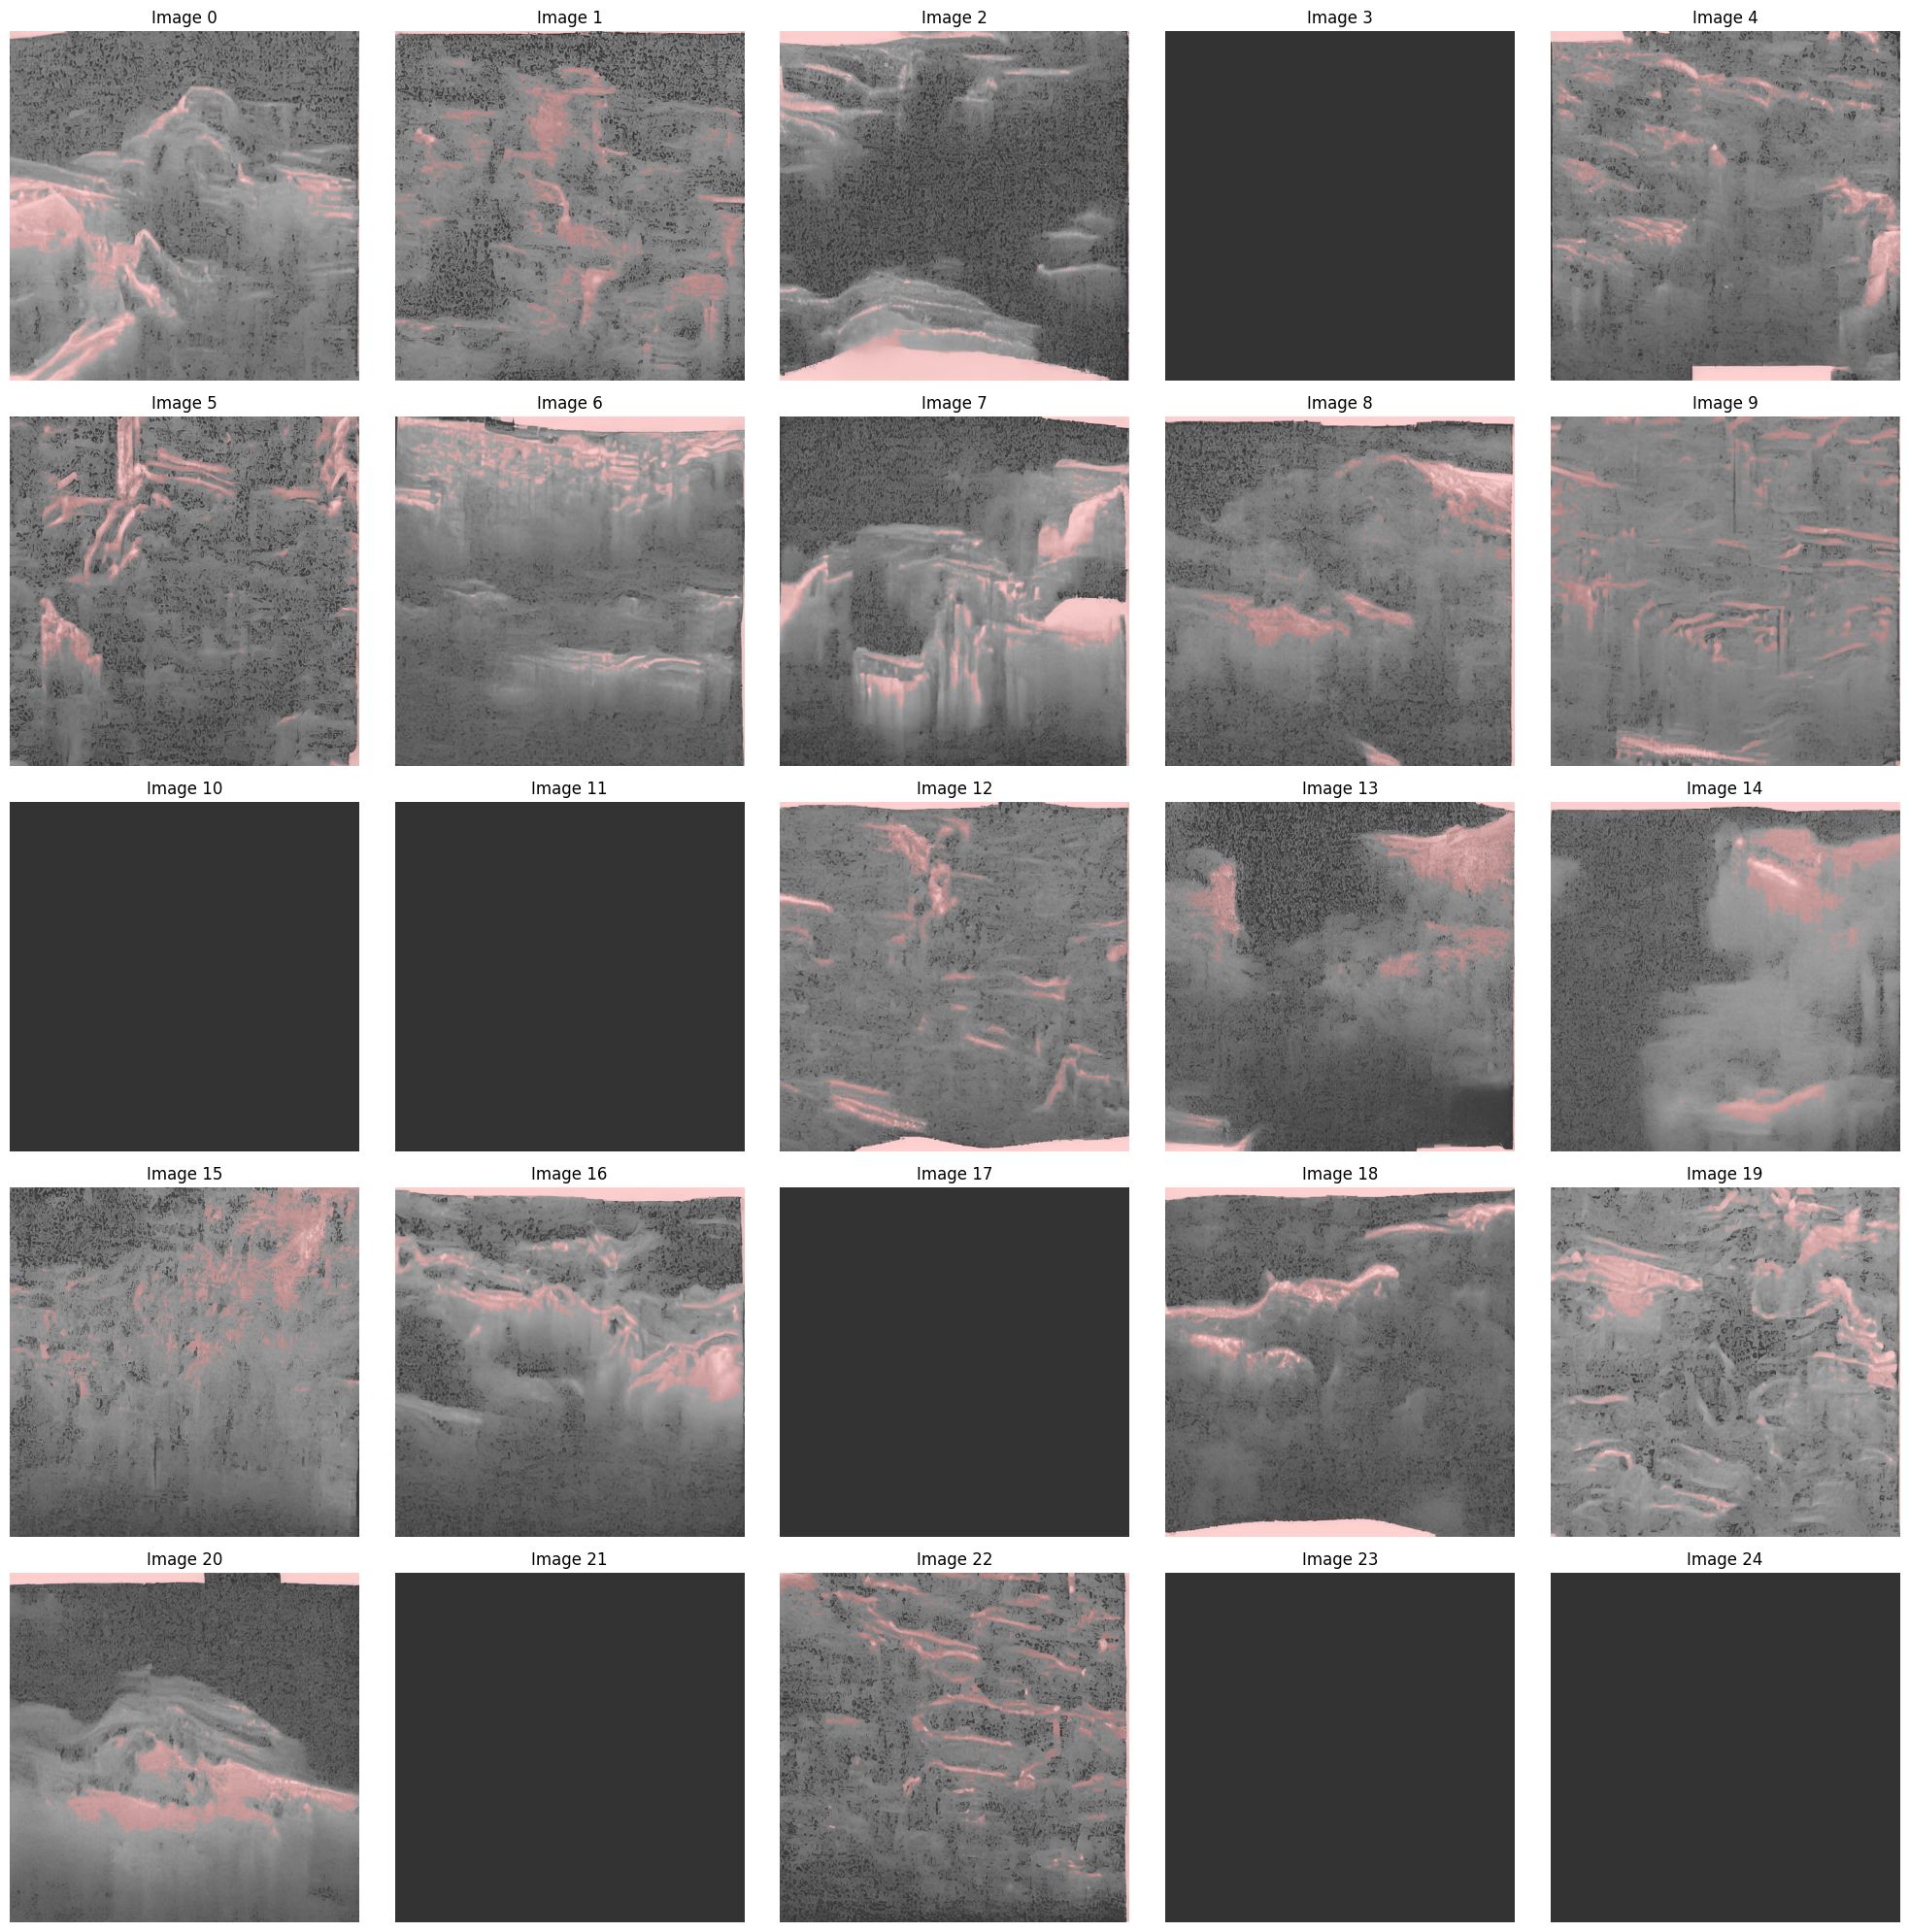

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import label

def get_cnv_mask(img, threshold_percentile=90, min_region_size=10):
    """
    Generate a binary mask for high-reflectance regions suspected to be CNV features.

    Parameters:
    - img (PIL.Image): Input image (grayscale)
    - threshold_percentile (float): Brightness threshold percentile
    - min_region_size (int): Minimum region size (number of pixels)

    Returns:
    - mask: Binary numpy array (1 for CNV regions, 0 elsewhere)
    """
    # Convert to grayscale (if not already)
    img_gray = img.convert("L")
    img_array = np.array(img_gray)

    # Calculate brightness threshold (top threshold_percentile%)
    threshold = np.percentile(img_array, threshold_percentile)

    # Create mask for high-reflectance regions
    high_reflectance = img_array > threshold

    # Label connected components
    labeled_array, num_features = label(high_reflectance)

    # Filter small regions
    mask = np.zeros_like(high_reflectance, dtype=np.uint8)
    for region_id in range(1, num_features + 1):
        region_mask = labeled_array == region_id
        if np.sum(region_mask) >= min_region_size:
            mask |= region_mask

    return mask

def display_synthetic_images_with_cnv_highlight(
    image_dir="/content/synthetic_cnv/",
    num_images=25,
    rows=5,
    cols=5,
    highlight_color=(255, 0, 0, 128),  # Red with 50% opacity
    threshold_percentile=90,
    min_region_size=10
):
    """
    Display synthetic CNV images in grayscale with high-reflectance regions highlighted in a colored overlay.

    Parameters:
    - image_dir (str): Directory path containing images
    - num_images (int): Number of images to display
    - rows (int): Number of rows in the grid
    - cols (int): Number of columns in the grid
    - highlight_color (tuple): RGBA color for highlight (R, G, B, A)
    - threshold_percentile (float): Brightness percentile for detecting high-reflectance regions
    - min_region_size (int): Minimum region size (number of pixels)
    """
    # Get list of image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    image_files.sort()

    if not image_files:
        print(f"Error: No images found in {image_dir}")
        return

    # Limit the number of images to display
    num_images = min(num_images, len(image_files))
    if num_images == 0:
        print("No images to display")
        return

    # Set up the grid
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.ravel() if num_images > 1 else [axes]

    # Load images and add highlight
    for i in range(num_images):
        img_path = os.path.join(image_dir, image_files[i])
        try:
            # Load image in grayscale
            img = Image.open(img_path).convert("L")

            # Get CNV mask
            cnv_mask = get_cnv_mask(img, threshold_percentile, min_region_size)

            # Convert grayscale to RGB for highlighting
            img_rgb = img.convert("RGB")
            img_array = np.array(img_rgb)

            # Create highlight overlay
            highlight = np.zeros((img.height, img.width, 4), dtype=np.uint8)
            highlight[cnv_mask > 0] = highlight_color

            # Convert highlight to PIL Image
            highlight_img = Image.fromarray(highlight, mode="RGBA")

            # Convert base image to RGBA for blending
            img_rgba = Image.fromarray(img_array).convert("RGBA")

            # Blend image with highlight
            blended = Image.blend(img_rgba, highlight_img, alpha=0.2)

            # Display with matplotlib
            axes[i].imshow(blended)
            axes[i].set_title(f"Image {i}")
            axes[i].axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            axes[i].axis('off')

    # Disable empty plots
    for i in range(num_images, rows * cols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Display synthetic CNV images with highlighted CNV regions
display_synthetic_images_with_cnv_highlight(
    image_dir="/content/synthetic_cnv/",
    num_images=25,
    rows=5,
    cols=5,
    highlight_color=(255, 0, 0, 128),  # Red with 50% opacity
    threshold_percentile=90,
    min_region_size=10
)